# GRAB IMAGE CHALLANGE SOLUTION


This notebook is setup in the google cloud platform<br>
using NVIDIA TESLA P100 as the main training device<br>

**Dataset**<br>
We are going to make the prediction of cars from the dataset provided by Grab team<br>
1. Link: https://ai.stanford.edu/~jkrause/cars/car_dataset.html <br>
2. Paper: [3D Object Representations for Fine-Grained Categorization](https://ai.stanford.edu/~jkrause/papers/3drr13.pdf)
<img src="https://github.com/polohot/grabsubmission/blob/master/grab_challange/data/Capture001.PNG">
This is about 6 years ago, They have achieved best accuracy for the 196 classes prediction of **69.5%** <br>
**Let see if we can do better!**

# FAST-AI LIBRARY
Fast-AI library has been my main package for the past year, not only it is easy to use but it does includes <br>
all the cutting edge technology for machine learning, also it get updated often <br>
for this data-set we will follow some of the guidelines provided by Jeremy Howard (FAST-AI) <br>

In [1]:
# Import library dependencies
import numpy as np
import pandas as pd
import scipy.io
import my_function as mf
import sys
from os import listdir
from os.path import isfile, join
from PIL import Image as PILImage
# Import Fast.ai Library
import fastai as fastai
from fastai.vision import *
from fastai.metrics import error_rate
pd.options.mode.chained_assignment = None

**gpu checker**

In [2]:
# check if GPU is avialiable for training
print ('Is cuda avialiable = ', torch.cuda.is_available())
print ('Is cudnn avialiable = ', torch.backends.cudnn.enabled)
print ('Available devices = ', torch.cuda.device_count())
print ('Current cuda device number = ', torch.cuda.current_device())
print ('Current cuda device name = ', torch.cuda.get_device_name(0))

Is cuda avialiable =  True
Is cudnn avialiable =  True
Available devices =  1
Current cuda device number =  0
Current cuda device name =  Tesla K80


In [3]:
# run this line if there is no GPU
#defaults.device = torch.device('cpu')

# Data Preperation

In [4]:
# We will import the mat files and convert to dataframe
mat_anno = scipy.io.loadmat('data/cars_annos.mat')

df_all = pd.DataFrame(np.hstack((mat_anno['annotations'])))
df_map = pd.DataFrame(np.hstack((mat_anno['class_names'])))

In [5]:
# show test=0 and test=1
df_all[44:46]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
44,[car_ims/000045.jpg],[[6]],[[7]],[[94]],[[68]],[[1]],[[0]]
45,[car_ims/000046.jpg],[[14]],[[16]],[[268]],[[169]],[[1]],[[1]]


In [6]:
# This function will split the into train and test set on "test" column
df_trn,df_tst = mf.make_tst_trn(df_all)

In [7]:
df_trn.head(3)

,name,cat
0,car_ims/000001.jpg,1
1,car_ims/000002.jpg,1
2,car_ims/000003.jpg,1


In [8]:
df_tst.head(3)

,name,cat
0,car_ims/000046.jpg,1
1,car_ims/000047.jpg,1
2,car_ims/000048.jpg,1


In [9]:
# Next we will add the car name using mapper "df_map"
df_map.head(3)

,0
0,[AM General Hummer SUV 2000]
1,[Acura RL Sedan 2012]
2,[Acura TL Sedan 2012]


In [10]:
# map category to the car name
df_trn['label'] = mf.make_label(df_trn,df_map)
df_tst['label'] = mf.make_label(df_tst,df_map)

In [11]:
df_trn.head(3)

,name,cat,label
0,car_ims/000001.jpg,1,AM General Hummer SUV 2000
1,car_ims/000002.jpg,1,AM General Hummer SUV 2000
2,car_ims/000003.jpg,1,AM General Hummer SUV 2000


In [12]:
df_tst.head(3)

,name,cat,label
0,car_ims/000046.jpg,1,AM General Hummer SUV 2000
1,car_ims/000047.jpg,1,AM General Hummer SUV 2000
2,car_ims/000048.jpg,1,AM General Hummer SUV 2000


In [13]:
df_trn = df_trn.reset_index(drop=True)
df_tst = df_tst.reset_index(drop=True)

df_trn_bkup = df_trn.copy()
df_tst_bkup = df_tst.copy()

# 1 - Feature Engineering

## 1a - Image crop with openCV - See better when looking closer

Lastest research from **march 2019** on this car dataset <br>
https://arxiv.org/pdf/1901.09891v2.pdf<br>
<img src="http://drive.google.com/uc?export=view&id=1xgQKsomcWNvA3B-m8hV5-NcjkbgZO90d">
**Research paper conclusion**<br>
Better result if instead of using the whole image, we crop the car first<br>
this will provide deeper feature to be trained on<br>
Research accuracy on this dataset (stanford car) = **94.5%**

**We will use openCV library to crop the image**<br>
This library provide pretrained model on top of openCV library<br>
Link: https://towardsdatascience.com/object-detection-with-10-lines-of-code-d6cb4d86f606<br>
<br>
<img src="http://drive.google.com/uc?export=view&id=1WzC6ZWrMrm3K3ihDUCNG6Akcrv1pZJsK">

I have done cropping in my personal computer, this is th function if you want to try<br>
The cropped image will be deposited into **car_crop_demo** folder<br>
It's gonna take quite some time

In [ ]:
# Don't run this
#create_cropped_data_and_save_in_folder(df_trn) 

In [15]:
# df_trn2 is for the cropped image
df_trn2 = df_trn.copy()
df_trn2['name'] = df_trn2['name'].str.slice_replace(0, 8, 'car_crop/')

## 1b - Image cleaning - mask out anything that could confuse the model<br>
To make sure less noise is introduced during training, we will mask out other car in the training set<br>
I did this on my laptop with photoshop, alternately you can use AI > image segmentation to automate this process<br>
but for competition sake, I feel better that I do this my self<br>
<img src="http://drive.google.com/uc?export=view&id=14-zUBNQonvUmIFu-QBX_S4FOus5jxLIW">

## 1c - Image Augmentation (Feature engineering)
We gonna use the get_transforms method provided by the fast.ai libraray<br>
It bascially take the original image and transforms it into more images<br> 
For example **stretching, zooming, rotating** so if you input one cat image it will create something like this<br>
This will provide more feature for the training set<br>
[Source](https://docs.fast.ai/vision.transform.html)<br>
<img src="http://drive.google.com/uc?export=view&id=1PuSVyTsoT5Fv5MGhGEFWSWWdnY6jnew5">

With this function you can preset how you want the image to be transformmed<br>
<br>
do_flip : flipping image horizontally = Yes, car can be coming from left and right, that makes sense<br>
flip_vert: flipping image vertically = No need, unless you are tryinng to predict an upsidedown car<br>
<br>
We will leave other settings to the default

In [16]:
# initiate image transforming function
tfms = get_transforms(do_flip=True,       
                      flip_vert=False)

## 1d - Create dataset for train and test<br>

**Join original data with cropped data**<br>
This will add more training data for the model<br>
This is intentional and will overfit the model to get the best accuracy on test set

In [17]:
# mf.make_databunch only takes 2 columns
df_trn = df_trn[['name','label']]
df_trn2 = df_trn2[['name','label']]
df_tst = df_tst[['name','label']]

In [18]:
# Join original data with cropped data
df_trn_all = df_trn.append(df_trn2).reset_index(drop=True)

<img src="http://drive.google.com/uc?export=view&id=1SWNo2JgvjxRsWrEWITi5YZxeDNwrrmhp">

# 2 - Train the model
**Here I will demonstrate traditional and competition approach**<br>
1. Traditional approach = Split **traning set** into **traning(80%)** and **validation(20%)** set<br>
2. Competition approach = Use whole **training set** for training, use **test set** for validation<br>

## 2.1 - Traditional Approach

In [19]:
# Load traning image and split 20% for validation
path='data/'
np.random.seed(0)
src = ImageList.from_df(path=path, df=df_trn_all).split_by_rand_pct(0.2).label_from_df()
src_test = ImageList.from_df(path=path, df=df_tst).split_none().label_from_df()

In [20]:
# Add test image into test set
src.test = src_test.train

In [21]:
# resize all to 64px and put all traning data into a class called "databunch"
sz=64 # image size
bs=64 # batch size
data = src.transform(tfms,size=sz).databunch(bs=bs)

In [22]:
# our data structure
data

ImageDataBunch;

Train: LabelList (13031 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: data;

Valid: LabelList (3257 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Jeep Grand Cherokee SUV 2012,Mercedes-Benz SL-Class Coupe 2009,BMW M5 Sedan 2010,Suzuki SX4 Sedan 2012,Ford F-150 Regular Cab 2012
Path: data;

Test: LabelList (8041 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: data

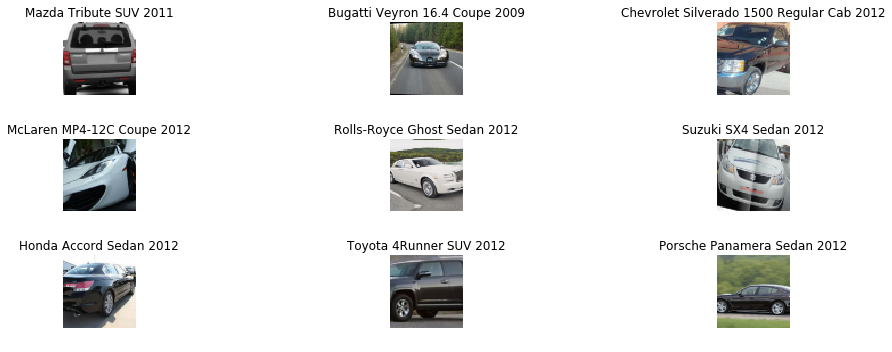

In [23]:
# Show some images in our data
data.show_batch(rows=3, figsize=(14,5))

## Use pretrained model (Resnet architecture)<br>
Instead of building and training the whole model from the beginning (normally I use keras CNN to do that)<br>
**fast.ai** library has a function that we can download pretrained model from pytorch site<br>
Now because resnet is a **pretrained model** on lots of image data by google <br>
It does already recognize the features of objects of the human world <br>
<br>
I have tried from 18 34 50 101 and 152, for best accuracy in the competition<br>
We will go with **resnet152** because we can hope to catch the most features<br>
In the realworld, we can get more training data and we can use smaller resnet for optimizing speed

**Example of resnet34 layer >>** <br>
<img src="http://drive.google.com/uc?export=view&id=1w7QoCe4t-I_E5LUWAoUGt60u6Z3VcDS4">


In [24]:
# define model
learn152 = cnn_learner(data, models.resnet152, metrics=[accuracy,error_rate])

In [25]:
# set default lr
lr = 1e-3

In [33]:
learn152.fit_one_cycle(6,max_lr=lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.594136,5.092262,0.041756,0.958244,01:32
1,4.898858,4.409943,0.096101,0.903899,01:31
2,4.298731,3.884025,0.162419,0.837581,01:31
3,3.824879,3.546400,0.216150,0.783850,01:32
4,3.522294,3.367344,0.247774,0.752226,01:32
5,3.368921,3.360389,0.247774,0.752226,01:31


## Learning Rate Annealing (fit_one_cycle)<br>

Normally we train the model using constant learning rate <br>
For this model we will fit the model using method called **"fit_one_cycle"** <br>
The model will be fitted with **increasing learning rate to max_lr then the learning rate will decrease**<br>
[Source](https://github.com/hiromis/notes/blob/master/Lesson3.md)<br>

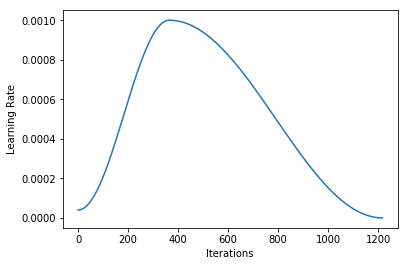

In [34]:
# plot learning rate
learn152.recorder.plot_lr()

## Unfreeze the pretrained model

The training above is just for the **few last layers** of resnet <br>
We would want to fine tune all of the layers to recognize our cars model better<br>
We can do that by **unfreeze** all the layers to be trainable <br>

In [35]:
# unfreeze all layers for training
learn152.unfreeze()

In [36]:
# Fit with lower learning rate
learn152.fit_one_cycle(6,max_lr=slice(lr/1000,lr/10))
learn152.save('152_64')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.323117,3.287600,0.258213,0.741787,01:56
1,3.242792,3.151703,0.279398,0.720602,01:55
2,3.086039,3.028037,0.301504,0.698496,01:55
3,2.956662,2.951003,0.318084,0.681916,01:55
4,2.866822,2.916082,0.322690,0.677310,01:55
5,2.831109,2.918559,0.322997,0.677003,01:55


In [27]:
# test set accuracy (new function)
print(mf.calc_accuracy(learn152,df_tst))

final accuracy = 0.24536749160552170.0% ...current accuracy 0.2454
0.2453674916055217


Validation accuracy = 32.2% / Test accuracy = 24.5%

Test accuracy is less, due to over fit from duplicate data<br>
But we will allow this because we know enforced duplication when creating train dataset<br>

We now have a model that is about **24.5%** accurate which is **really bad**, maybe the image **64x64px** is too small<br>
Let's see what we can do next

## Progressive resizing
This is the concept of training the model with low resolution at first<br>
Then gradually increased resolution and fit into the model again<br>
[Source](https://towardsdatascience.com/boost-your-cnn-image-classifier-performance-with-progressive-resizing-in-keras-a7d96da06e20)<br>
**Something like this**<br>
<img src="http://drive.google.com/uc?export=view&id=1TKKkLY269Z0oYO2v8DxCQDB9i-42w-kk">
<br>
We can also use a hi-res image from the beginning,<br> 
But this method has proven to generalize the model better and **reduce over-fitting**<br><br>
Now we will use the same model but train with new data<br>
In this case **upsize the image from 64px to 96px**<br>
For the model perspective, **this is a totally new dataset** so it is like we are adding new data be avialiable to be trained

In [24]:
sz=96; bs=64; cycle=6
#learn152.load('152_64')
learn152 = mf.transfer_learner(src,learn152,tfms,sz,bs,cycle,lr=lr)
learn152.save('152_96')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.749055,2.580418,0.394842,0.605158,02:26
1,2.550589,2.305111,0.433221,0.566779,02:17
2,2.193411,1.988214,0.490636,0.509364,02:18
3,1.911810,1.733355,0.552963,0.447037,02:17
4,1.644687,1.595423,0.582131,0.417869,02:18
5,1.559540,1.569500,0.587350,0.412650,02:17


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.505269,1.528082,0.599325,0.400675,03:08
1,1.473417,1.447758,0.616518,0.383482,03:06
2,1.359357,1.364781,0.637396,0.362604,03:06
3,1.230284,1.310845,0.655204,0.344796,03:07
4,1.171193,1.273936,0.658581,0.341418,03:07
5,1.131583,1.275902,0.657353,0.342647,03:06


In [25]:
# test set accuracy (old function)
print(mf.calc_accuracy(learn152,df_tst))

2000 0.4685
4000 0.5035
6000 0.5325
8000 0.544125
0.5452058201716204


In [26]:
# Upsize to 144px
sz=144; bs=64; cycle=6
learn152 = mf.transfer_learner(src,learn152,tfms,sz,bs,cycle,lr=1e-3)
learn152.save('152_144')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.177230,1.084948,0.720909,0.279091,04:37
1,1.208058,1.078194,0.705864,0.294136,04:25
2,1.068972,0.964137,0.732576,0.267424,04:25
3,0.876500,0.806209,0.775253,0.224747,04:26
4,0.722970,0.710168,0.800737,0.199263,04:26
5,0.635631,0.698581,0.805342,0.194658,04:25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.622377,0.683875,0.809948,0.190052,05:58
1,0.629003,0.653566,0.820694,0.179306,05:56
2,0.556140,0.613086,0.827142,0.172858,05:55
3,0.510097,0.585564,0.833282,0.166718,05:56
4,0.444015,0.569100,0.838502,0.161498,05:56
5,0.438634,0.567719,0.838195,0.161805,05:55


In [27]:
# test set accuracy (old function)
print(mf.calc_accuracy(learn152,df_tst))

2000 0.692
4000 0.7195
6000 0.7365
8000 0.74875
0.7492849148115907


**Accuracy better than methods in research paper**<br>
Our test set accuracy is now 74.9% better than 69.5% from the 2012 research paper<br>
And we took around 1 hour to train the resnet152 model to this point!

In [28]:
# Upsize to 216px
sz=216; bs=32; cycle=6
#learn152.load('152_144')
learn152 = mf.transfer_learner(src,learn152,tfms,sz,bs,cycle,lr=1e-3)
learn152.save('152_216')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.683574,0.614324,0.827449,0.172551,09:22
1,0.834764,0.678201,0.813632,0.186368,09:11
2,0.822030,0.618985,0.830212,0.169788,09:11
3,0.602884,0.490506,0.854467,0.145533,09:10
4,0.444977,0.410229,0.875959,0.124041,09:11
5,0.387786,0.396859,0.881486,0.118514,09:11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.356623,0.393307,0.888855,0.111145,12:17
1,0.387778,0.392036,0.886399,0.113601,12:15
2,0.340596,0.365310,0.888855,0.111145,12:16
3,0.289529,0.333523,0.903592,0.096408,12:15
4,0.222357,0.314282,0.904513,0.095487,12:15
5,0.226685,0.313193,0.904820,0.095180,12:16


In [29]:
# test set accuracy (old function)
print(mf.calc_accuracy(learn152,df_tst))

2000 0.789
4000 0.80825
6000 0.8293333333333334
8000 0.839125
0.8393234672304439


In [24]:
# Upsize to 324px
sz=324; bs=16; cycle=6
learn152 = mf.transfer_learner(src,learn152,tfms,sz,bs,cycle,lr=5e-4)
learn152.save('152_324')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.454433,0.373399,0.888241,0.111759,20:58
1,0.534028,0.403827,0.879951,0.120049,20:53
2,0.534692,0.364609,0.889469,0.110531,21:00
3,0.439846,0.319675,0.903592,0.096408,20:57
4,0.309743,0.286524,0.912496,0.087504,20:58
5,0.282299,0.277060,0.914338,0.085662,20:54


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.269909,0.280223,0.913110,0.086890,27:19
1,0.294981,0.277627,0.915566,0.084434,27:36
2,0.276185,0.264792,0.921707,0.078293,27:36
3,0.248803,0.243729,0.923549,0.076451,27:37
4,0.205256,0.238857,0.930918,0.069082,27:24
5,0.178056,0.236316,0.927234,0.072766,27:27


In [25]:
# test set accuracy (old function)
print(mf.calc_accuracy(learn152,df_tst))

2000 0.8335
4000 0.85
6000 0.8728333333333333
8000 0.88175
0.8818554906106205


In [24]:
# Upsize to 486px
sz=486; bs=16; cycle=6
learn152 = mf.transfer_learner(src,learn152,tfms,sz,bs,cycle,lr=5e-4)
learn152.save('152_486')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.391411,0.340865,0.898680,0.101320,09:54
1,0.488279,0.366000,0.893460,0.106540,09:44
2,0.428648,0.335611,0.901750,0.098250,09:44
3,0.369225,0.283798,0.918330,0.081670,09:45
4,0.278469,0.252557,0.924163,0.075837,09:45
5,0.241937,0.244504,0.926006,0.073994,09:44


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.230987,0.249622,0.922321,0.077679,13:07
1,0.254753,0.256452,0.921707,0.078293,13:04
2,0.200094,0.232625,0.931839,0.068161,13:04
3,0.181464,0.224665,0.934602,0.065398,13:04
4,0.174962,0.209432,0.938594,0.061406,13:04
5,0.169256,0.210379,0.940436,0.059564,13:04


In [37]:
# test set accuracy (old function)
print(mf.calc_accuracy(learn152,df_tst))

2000 0.85
4000 0.866
6000 0.8898333333333334
8000 0.900125
0.9006342494714588


In [26]:
learn152.export('export152_486.pkl')

Final test set accuracy = 90.06%

## 2.2 - Competition Approach
Competition approach = Use whole **training set** for training, use **test set** for validation<br>
We can use the validation accuracy directly to detemine the test accuracy, as it is the test set

In [50]:
# Load training image and test image
path='data/'
np.random.seed(0)
src_all = ImageList.from_df(path=path, df=df_trn_all).split_none().label_from_df()
src_test = ImageList.from_df(path=path, df=df_tst).split_none().label_from_df()

In [51]:
# Add test image into validation set
src_all.valid = src_test.train

In [56]:
# Resize all pictures to 64 px
sz=486 # image size
bs=64 # batch size
data_all = src_all.transform(tfms,size=sz).databunch(bs=bs)

In [57]:
# Define model
learn152_all = cnn_learner(data_all, models.resnet152, metrics=[accuracy,error_rate])

In [58]:
learn152_all.data = data_all

In [31]:
lr = 1e-3

In [29]:
sz=64; bs=64; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_64')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.414823,5.062272,0.042656,0.957344,01:36
1,4.599846,4.358738,0.099988,0.900012,01:34
2,3.990877,3.891674,0.151971,0.848029,01:34
3,3.549768,3.653605,0.191643,0.808357,01:36
4,3.396385,3.596726,0.194628,0.805372,01:35


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.311414,3.535906,0.205198,0.794802,01:38
1,3.163687,3.401927,0.229698,0.770302,01:38
2,3.017096,3.357665,0.245741,0.754259,01:36
3,2.910330,3.246958,0.256187,0.743813,01:39
4,2.845914,3.252064,0.260291,0.739709,01:37


In [31]:
sz=96; bs=64; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_96')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.665935,2.649869,0.364756,0.635244,01:45
1,2.357289,2.370340,0.403557,0.596443,01:44
2,2.054975,2.075943,0.473449,0.526551,01:45
3,1.696473,1.904870,0.508892,0.491108,01:44
4,1.561774,1.872727,0.519836,0.480164,01:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.554211,1.837529,0.529412,0.470588,01:49
1,1.463872,1.755733,0.540729,0.459271,01:49
2,1.344852,1.674378,0.566099,0.433901,01:49
3,1.210565,1.641385,0.574680,0.425320,01:49
4,1.167691,1.623766,0.580525,0.419475,01:49


In [ ]:
sz=144; bs=64; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_144')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.161168,1.190276,0.673175,0.326825,02:06
1,1.185405,1.153152,0.680015,0.319985,02:03
2,0.933850,1.041132,0.713593,0.286407,02:03
3,0.756202,0.954657,0.735605,0.264395,02:02
4,0.655742,0.925692,0.741699,0.258301,02:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.611234,0.914566,0.745927,0.254073,02:27
1,0.623450,0.883777,0.752643,0.247357,02:28
2,0.548031,0.849706,0.762592,0.237408,02:27
3,0.471625,0.830152,0.770178,0.229822,02:28
4,0.460741,0.822339,0.772168,0.227832,02:28


In [33]:
sz=216; bs=32; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_216')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.671653,0.767641,0.778510,0.221490,03:32
1,0.842043,0.842760,0.762467,0.237533,03:29
2,0.652432,0.680972,0.806740,0.193260,03:30
3,0.509938,0.597459,0.826390,0.173610,03:28
4,0.397886,0.572674,0.834100,0.165900,03:27


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.382695,0.575393,0.830618,0.169382,04:24
1,0.411275,0.566734,0.833354,0.166646,04:23
2,0.335391,0.547218,0.844920,0.155080,04:22
3,0.250927,0.516574,0.850392,0.149608,04:22
4,0.227022,0.510516,0.853750,0.146250,04:23


In [34]:
sz=324; bs=16; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_324')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.679398,0.567741,0.840443,0.159557,06:55
1,0.797993,0.596371,0.830618,0.169382,06:50
2,0.650587,0.501712,0.855988,0.144012,06:49
3,0.436514,0.426544,0.879741,0.120259,06:49
4,0.353706,0.408290,0.887452,0.112548,06:49


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.383519,0.426737,0.879368,0.120632,08:53
1,0.346603,0.432960,0.883472,0.116528,08:52
2,0.302071,0.396393,0.889069,0.110931,08:52
3,0.228235,0.370675,0.896779,0.103221,08:52
4,0.210855,0.365062,0.898769,0.101231,08:52


In [35]:
sz=486; bs=12; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr)
learn152_all.save('152_all_486')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.518997,0.443545,0.878125,0.121875,14:13
1,0.747454,0.503252,0.863201,0.136799,14:06
2,0.518855,0.440274,0.881980,0.118020,14:06
3,0.395180,0.352329,0.903122,0.096878,14:07
4,0.296165,0.341309,0.908842,0.091158,14:06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.301156,0.356625,0.902997,0.097003,18:40
1,0.302136,0.383459,0.898644,0.101356,18:38
2,0.266996,0.335724,0.911205,0.088795,18:38
3,0.197138,0.315293,0.917423,0.082577,18:38
4,0.186403,0.313982,0.916055,0.083945,18:37


In [36]:
sz=486; bs=12; cycle=5
learn152_all = mf.transfer_learner(src_all,learn152_all,tfms,sz,bs,cycle,lr=lr/10)
learn152_all.save('152_all_486_1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.158151,0.304805,0.919537,0.080463,14:07
1,0.166346,0.313664,0.916553,0.083447,14:06
2,0.158194,0.312403,0.917796,0.082204,14:08
3,0.148703,0.310531,0.919164,0.080836,14:07
4,0.149800,0.309282,0.919910,0.080090,14:08


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.137300,0.307903,0.917921,0.082079,18:41
1,0.176626,0.306594,0.921030,0.078970,18:40
2,0.137623,0.312886,0.919662,0.080338,18:39
3,0.126251,0.305164,0.920781,0.079219,18:39
4,0.123130,0.306175,0.922273,0.077727,18:38


In [67]:
learn152_all.export('export152_all_486.pkl')

Final test set accuracy = 92.22% 

# 3 - Make predictions
after trying both approach, I have chosen competition approach to submit due to higher accuracy on the test dataset<br>

## 3.1 - Individual image prediction

In [2]:
# load the model
learn = load_learner('data/','export152_all_486.pkl')
# run this line if no GPU
#defaults.device = torch.device('cpu')

In [4]:
# Individual image prediction
img = open_image('hold_out_images/0008.jpg')
pred_class,_,conf = learn.predict(img) 

In [5]:
# show predicted category
pred_class

Category BMW M6 Convertible 2010

In [6]:
# show confident for each category
conf

tensor([3.2288e-11, 3.3572e-10, 1.7860e-10, 3.9358e-10, 9.7659e-08, 1.6510e-08,
        9.8379e-09, 6.0402e-06, 6.6780e-11, 8.1719e-08, 4.6822e-09, 1.5527e-09,
        4.9721e-11, 2.0579e-11, 4.5598e-10, 9.5477e-08, 5.9706e-12, 8.5874e-10,
        1.0960e-07, 7.4061e-11, 3.3155e-10, 5.9919e-10, 1.2864e-10, 2.9945e-09,
        2.8206e-09, 2.7846e-07, 6.7685e-11, 1.2012e-08, 1.0957e-07, 4.8955e-02,
        2.6098e-07, 3.3682e-07, 1.2192e-08, 9.5103e-01, 4.7073e-08, 2.5941e-08,
        1.2522e-08, 3.5153e-06, 8.7633e-11, 1.5943e-09, 7.1403e-08, 1.4588e-08,
        3.4137e-08, 1.2169e-09, 2.8185e-08, 1.2870e-08, 1.0165e-08, 2.6325e-08,
        6.0102e-09, 3.1276e-08, 1.4101e-09, 2.7602e-10, 1.2550e-10, 4.8443e-10,
        4.5544e-07, 3.4470e-10, 2.5942e-08, 8.4735e-11, 9.7452e-11, 2.5449e-09,
        9.4542e-11, 5.1154e-10, 9.9774e-09, 4.7498e-09, 4.6296e-10, 1.2282e-10,
        3.1987e-09, 1.5739e-09, 9.1550e-10, 1.0737e-08, 1.6404e-10, 8.7200e-11,
        1.1303e-09, 1.1769e-10, 1.0686e-

## 3.2 - Test set prediction

In [28]:
# load the model
learn = load_learner('data/','export152_all_486.pkl')
# run this line if there is no GPU
#defaults.device = torch.device('cpu')

In [29]:
df_tst = mf.load_df_tst()

In [30]:
# this will take some time
score, confident = mf.calc_accuracy2(learn,df_tst)

final accuracy = 0.92227334908593460.0% ...current accuracy 0.9223


In [43]:
# show confident for each class
confident

,0,1,2,3,4,5,6,7,8,9,...,8031,8032,8033,8034,8035,8036,8037,8038,8039,8040
0,9.993339e-01,9.999985e-01,9.999846e-01,9.995829e-01,7.523528e-01,1.000000e+00,9.995973e-01,1.000000e+00,9.999986e-01,6.081337e-01,...,8.949994e-09,1.089885e-07,8.046610e-10,1.216665e-05,1.866082e-08,6.907706e-08,1.121230e-10,1.198812e-08,7.919173e-05,1.211354e-08
1,2.001527e-10,9.972310e-12,2.035539e-10,3.749713e-10,3.257218e-08,2.321837e-13,3.401021e-10,9.437089e-12,6.629173e-11,5.500523e-06,...,6.103723e-10,5.782711e-07,4.109048e-09,2.024488e-05,9.606081e-08,7.068838e-07,2.129679e-09,9.825772e-08,4.167639e-05,3.894307e-10
2,4.643946e-10,3.112035e-12,3.297911e-10,1.924430e-10,1.821201e-08,7.519426e-16,6.841430e-10,1.282632e-12,6.352839e-12,8.201028e-05,...,4.496189e-12,9.815764e-08,4.526099e-11,2.193503e-05,3.292429e-09,1.246280e-08,7.272564e-10,7.535287e-09,4.712113e-06,1.649476e-09
3,2.136015e-09,6.612071e-12,1.485439e-10,1.523948e-09,5.315997e-08,3.574721e-16,1.200540e-08,2.173834e-12,1.155075e-11,1.508306e-05,...,1.440261e-10,3.767559e-06,2.109661e-09,1.439293e-07,4.217865e-09,1.281499e-06,1.038608e-10,1.211201e-10,8.668283e-08,6.582936e-10
4,1.065457e-11,9.740735e-14,1.124637e-11,3.788792e-11,2.504015e-09,5.533002e-17,3.201469e-08,5.264384e-13,7.874252e-13,3.588124e-06,...,1.145039e-06,7.563971e-08,1.217946e-08,2.373263e-05,1.199509e-07,6.995074e-06,7.130897e-09,4.966912e-07,2.868625e-06,1.745975e-10
5,1.174123e-08,2.099855e-10,5.715541e-11,2.620049e-10,5.408974e-06,8.168494e-15,1.286053e-10,7.751234e-14,5.813651e-11,3.275191e-04,...,2.145043e-08,2.426981e-04,1.746749e-07,1.851571e-04,8.446949e-07,8.628974e-07,1.478720e-07,1.207724e-07,9.099761e-06,1.277298e-06
6,1.527803e-08,4.814179e-12,2.216289e-10,1.879865e-10,1.223714e-06,1.724999e-16,5.830439e-10,3.910255e-13,6.759274e-12,2.817358e-06,...,9.307954e-10,1.218108e-06,3.117240e-09,9.497321e-06,1.010598e-08,7.148382e-08,1.119840e-08,2.050563e-08,4.772387e-07,1.931588e-09
7,8.042114e-10,1.525748e-09,5.833410e-10,1.659296e-09,1.233232e-04,1.148924e-13,4.730460e-09,5.450285e-10,9.339138e-10,9.620559e-04,...,4.038892e-08,6.318136e-07,1.883986e-08,1.564819e-04,7.779623e-07,2.153783e-06,3.023971e-09,5.578826e-08,2.381068e-04,2.896987e-09
8,3.933785e-10,1.578068e-09,9.782046e-10,8.041280e-10,2.128520e-04,2.296088e-12,1.005252e-10,2.388592e-09,2.757792e-10,5.270799e-05,...,1.855111e-10,1.633424e-07,1.833646e-10,4.861457e-07,9.509553e-08,2.949509e-06,8.762746e-12,8.771728e-10,1.080461e-04,2.229596e-10
9,8.309510e-11,2.906789e-12,2.127733e-10,1.489889e-10,7.409244e-07,4.692577e-16,6.249611e-11,3.688683e-11,2.422759e-12,1.788096e-06,...,9.486954e-11,5.444623e-08,1.740388e-09,1.500434e-05,1.312319e-08,3.734385e-07,9.034192e-10,1.529787e-08,4.181224e-06,5.950024e-10


## 3.3 - Hold out image prediction
please put all images into **/hold_out_images/*** directory

In [33]:
# lists of file in hold_out_images folder
file_lists = [f for f in listdir('hold_out_images') if isfile(join('hold_out_images', f))]
file_lists.sort()

In [40]:
ls_prd = []
df_conf=pd.DataFrame()
for i in range(0,len(file_lists)):
    mf.progress(i, len(file_lists)-1, status='predicting')
    img = open_image('hold_out_images/'+str(file_lists[i]))
    pred,_,conf = learn.predict(img)
    ls_prd.append(str(pred))
    df_conf[str(file_lists[i])] = pd.Series(conf) 
print('prediction complete')

prediction complete============] 100.0% ...predicting


In [41]:
# show predicted name
ls_prd

['AM General Hummer SUV 2000',
 'Bentley Continental GT Coupe 2007',
 'Chevrolet Cobalt SS 2010',
 'AM General Hummer SUV 2000',
 'Aston Martin Virage Coupe 2012',
 'Audi S5 Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW M6 Convertible 2010',
 'Bentley Continental GT Coupe 2007',
 'Chrysler PT Cruiser Convertible 2008',
 'Ford GT Coupe 2006',
 'HUMMER H3T Crew Cab 2010',
 'Hyundai Genesis Sedan 2012',
 'Land Rover Range Rover SUV 2012',
 'Mercedes-Benz S-Class Sedan 2012',
 'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
 'Tesla Model S Sedan 2012']

In [42]:
# show confident for each class
df_conf

,0001.jpg,0002.jpg,0003.jpg,0004.jpg,0005.jpg,0006.jpg,0007.jpg,0008.jpg,0009.jpg,0010.jpg,0011.jpg,0012.jpg,0013.jpg,0014.jpg,0015.jpg,0016.jpg,0017.jpg
0,9.946898e-01,5.527040e-10,0.000012,9.999048e-01,6.342999e-10,1.183973e-07,2.920415e-08,3.228828e-11,3.060639e-09,7.223971e-12,3.107398e-03,8.358906e-04,9.808090e-09,1.484721e-07,5.011221e-07,3.447901e-10,2.308487e-09
1,1.899340e-09,9.535163e-10,0.000017,1.761112e-10,2.843292e-10,9.534995e-08,1.577303e-07,3.357163e-10,6.449487e-07,1.623714e-11,1.347514e-04,2.516514e-08,4.195890e-09,2.993035e-09,5.810283e-06,1.106025e-09,2.129157e-09
2,1.151257e-09,4.426668e-07,0.008731,5.013019e-10,1.051545e-08,3.067652e-05,1.381031e-08,1.785981e-10,4.494233e-08,1.587462e-12,3.968005e-08,1.769505e-08,8.201303e-08,1.401909e-08,2.269895e-06,5.251202e-12,2.393463e-07
3,1.804574e-09,8.469987e-09,0.000743,2.391208e-09,4.873421e-10,4.288192e-06,9.127382e-08,3.935806e-10,1.717001e-07,3.138831e-14,3.735467e-08,1.157479e-08,8.039961e-08,1.119818e-09,3.331982e-06,4.676205e-11,1.442675e-06
4,1.558161e-09,2.228586e-10,0.030481,3.972249e-10,2.024582e-09,7.951560e-08,7.399468e-07,9.765855e-08,4.193754e-08,3.327225e-11,4.138649e-07,1.671449e-07,9.258383e-09,4.804226e-08,7.735549e-07,3.240967e-07,1.173524e-07
5,2.282022e-09,8.116959e-08,0.048610,6.930124e-10,1.567931e-10,8.513180e-07,2.216754e-05,1.650971e-08,1.731278e-07,1.050820e-10,5.084740e-07,3.129542e-08,1.305973e-07,7.531119e-10,7.110676e-08,5.392082e-11,1.809938e-09
6,4.951609e-09,2.196917e-09,0.000285,5.644619e-09,2.101966e-09,7.496948e-08,3.097405e-10,9.837883e-09,4.550723e-08,9.414716e-13,9.404335e-08,5.651505e-07,8.398666e-10,1.202819e-07,8.990731e-07,2.185206e-12,2.990126e-07
7,7.656271e-08,3.742555e-08,0.000921,1.027033e-08,8.294963e-07,9.766996e-08,4.555581e-09,6.040210e-06,5.926113e-07,1.334036e-08,2.867151e-06,5.287514e-08,1.293285e-10,2.271239e-08,8.376779e-06,1.453228e-06,3.462408e-06
8,3.427322e-09,3.187678e-06,0.004024,3.105421e-09,2.044085e-04,1.865009e-05,7.342465e-09,6.678041e-11,2.009899e-04,2.473205e-12,1.347017e-06,1.067687e-09,4.547209e-09,2.711424e-09,6.436066e-06,1.481806e-07,1.382336e-05
9,1.470955e-09,1.107155e-07,0.000007,7.863321e-10,4.646421e-06,2.312602e-06,1.832089e-09,8.171873e-08,1.319706e-08,1.234997e-08,3.966601e-06,4.173092e-09,1.610923e-09,6.136532e-07,1.482317e-06,2.520344e-11,3.418560e-06
